# Исследование объявлений о продаже квартир

В наличии данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры, влияющие на цену. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Загрузка и изучение исходных данных

E:\Yandex Notebooks
   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          

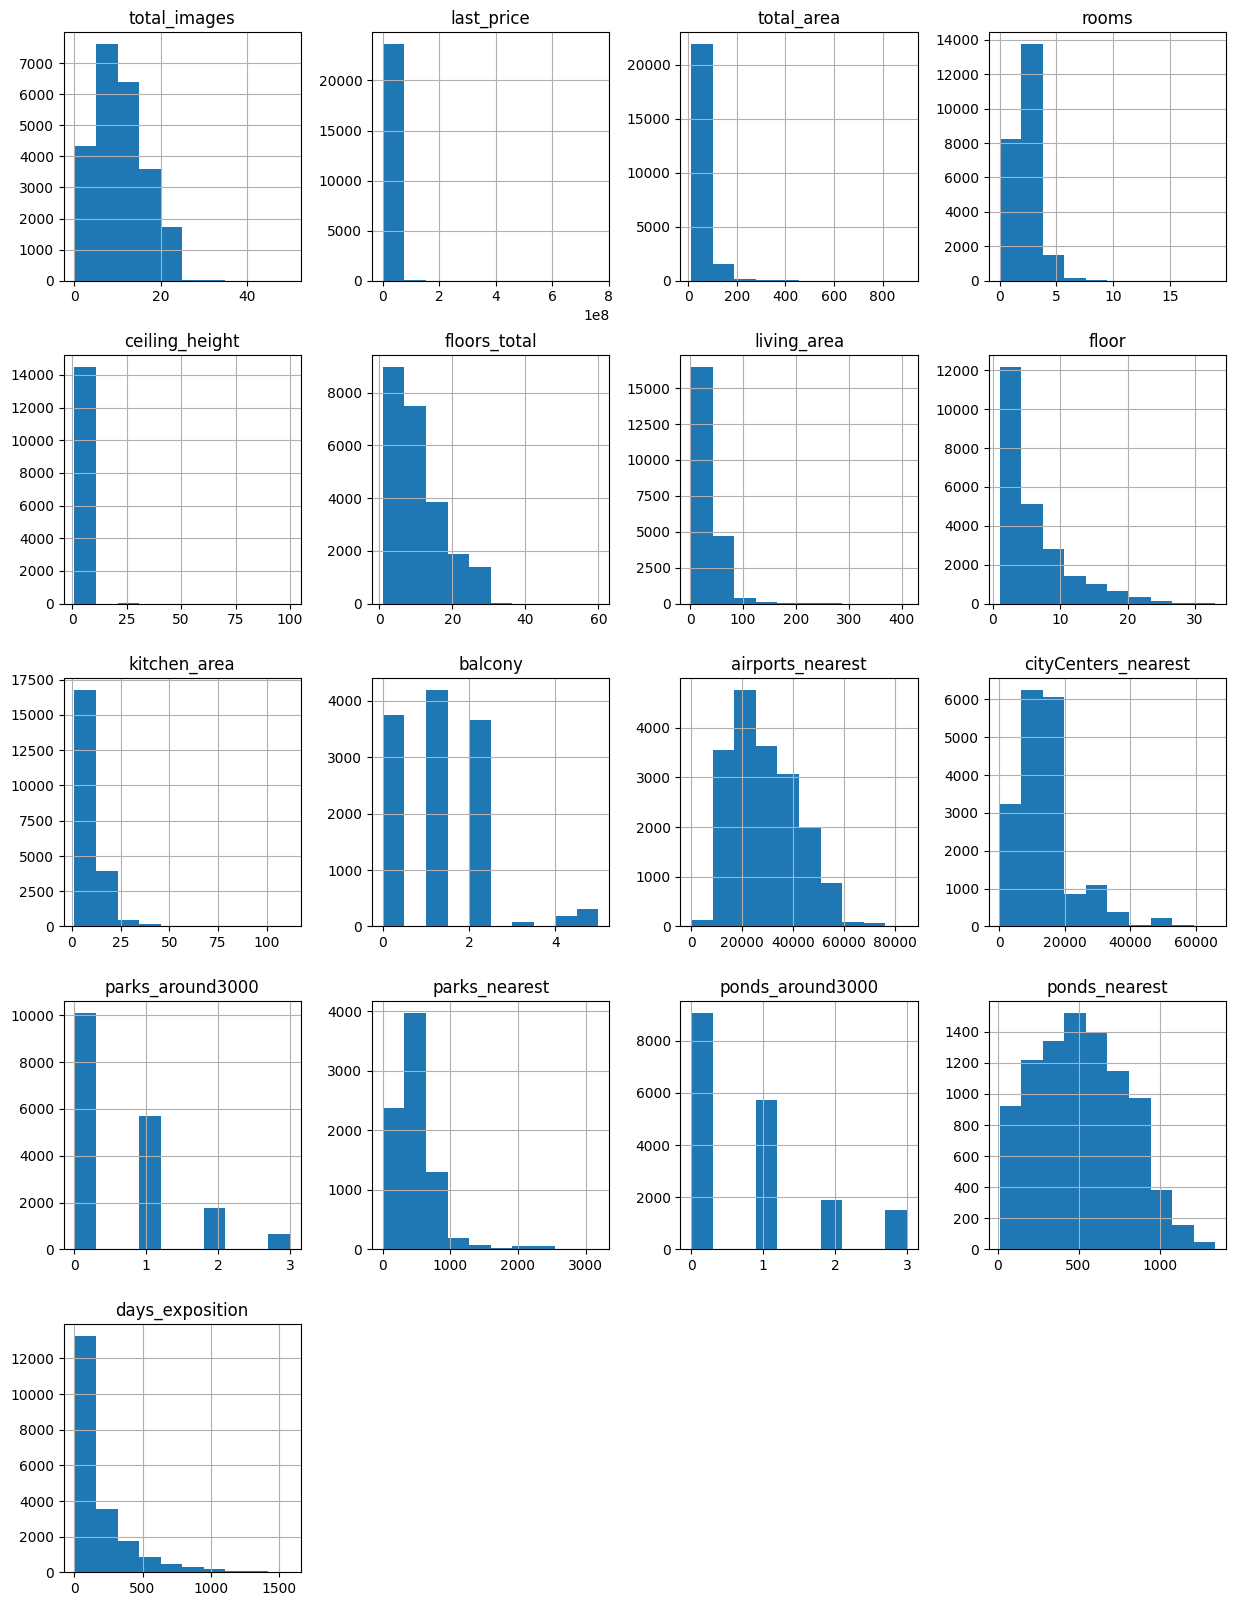

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print(os. getcwd())
pd.set_option('display.max_columns', None)

df = pd.read_csv('datasets/real_estate_data.csv', sep='\t')
print(df.head())
df.info()
df.hist(figsize=(15, 20))
plt.show()

Из общей информации понятно, что пропуски есть в столбцах ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition. На диаграммах многих переменных заметны редко встречающиеся большие значения, которые в дальнейшем предстоит отсеять.

## Предобработка данных

### Восстановление пропущенных значений

Посчитаем пропуски всех столбцов:

In [2]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Вероятно, если не указано иное, недвижимость не является апартаментами, так что заполним отсутствующие значения этой переменной значением False:

In [3]:
print(len(df[df['is_apartment'].isnull()]))
df['is_apartment'] = df['is_apartment'].fillna(False)
df

20924


C:\Users\hydro\AppData\Local\Temp\ipykernel_7820\2426533771.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_apartment'] = df['is_apartment'].fillna(False)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,False,False,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,False,False,False,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,False,False,False,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,False,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


Посмотрим на наименьшие возможные значения переменной days_exposition. Возможно, те объявления, которые были выставлены менее одного дня, получили значения nan вместо ноля. Убедимся в этом:

In [4]:
sorted(df['days_exposition'].unique())[:5]

[nan, 1.0, 2.0, 3.0000000000000004, 4.0]

Наконец, можно предположить, что отсутствующие значения в переменных balcony, parks_around3000, ponds_around3000 означают отсутствие балконов в квартире, а также парков и прудов поблизости. Заменим пропущенные значения из days_exposition и этих столбцов на 0:

In [5]:
vars_to_fillna = ['days_exposition', 'balcony', 'parks_around3000', 'ponds_around3000']
df[vars_to_fillna] = df[vars_to_fillna].fillna(0)
df

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0.0
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,False,False,False,13.83,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,0.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,False,False,False,8.50,0.0,Тосно,NaN,NaN,0.0,NaN,0.0,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,False,False,False,NaN,0.0,село Рождествено,NaN,NaN,0.0,NaN,0.0,NaN,0.0
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,False,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


Пропущенные значения в названии населённого пункта и количестве этажей крайне редки и не могут быть адекватным образом восстановлены. Проще всего удалить их:

In [6]:
df = df.dropna(subset=['locality_name', 'floors_total']).reset_index()

Пропущенные значения в высоте потолков слишком частые, чтобы их можно было удалить. Попробуем примерно восстановить их через медианную высоту потолков для данной этажности:

In [7]:
df['floors_limited'] = df['floors_total'].where(df['floors_total']<=20, 20)
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df.groupby('floors_limited')['ceiling_height'].transform('median')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 23565 non-null  int64  
 1   total_images          23565 non-null  int64  
 2   last_price            23565 non-null  float64
 3   total_area            23565 non-null  float64
 4   first_day_exposition  23565 non-null  object 
 5   rooms                 23565 non-null  int64  
 6   ceiling_height        23565 non-null  float64
 7   floors_total          23565 non-null  float64
 8   living_area           21700 non-null  float64
 9   floor                 23565 non-null  int64  
 10  is_apartment          23565 non-null  bool   
 11  studio                23565 non-null  bool   
 12  open_plan             23565 non-null  bool   
 13  kitchen_area          21343 non-null  float64
 14  balcony               23565 non-null  float64
 15  locality_name      

Пропущенные значения в жилой площади слишком важны, чтобы их можно было удалить. Попробуем примерно восстановить их через медианную долю от общей площади для данной этажности:

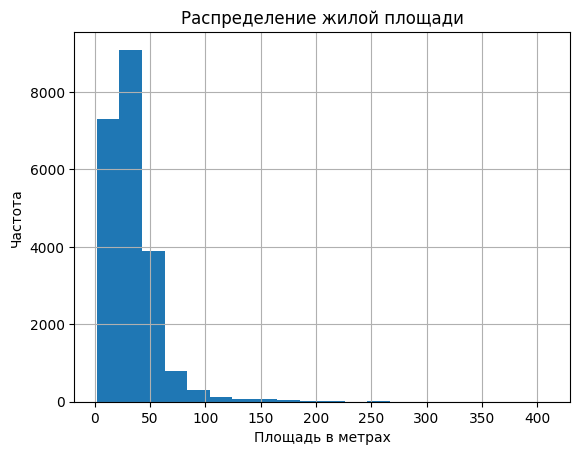

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 23565 non-null  int64  
 1   total_images          23565 non-null  int64  
 2   last_price            23565 non-null  float64
 3   total_area            23565 non-null  float64
 4   first_day_exposition  23565 non-null  object 
 5   rooms                 23565 non-null  int64  
 6   ceiling_height        23565 non-null  float64
 7   floors_total          23565 non-null  float64
 8   living_area           23565 non-null  float64
 9   floor                 23565 non-null  int64  
 10  is_apartment          23565 non-null  bool   
 11  studio                23565 non-null  bool   
 12  open_plan             23565 non-null  bool   
 13  kitchen_area          21343 non-null  float64
 14  balcony               23565 non-null  float64
 15  locality_name      

In [8]:
df['living_area'].hist(bins=20)
plt.title('Распределение жилой площади')
plt.xlabel('Площадь в метрах')
plt.ylabel('Частота')
plt.show()

df.loc[df['living_area'].isna(), 'living_area'] = (df
                                                   .assign(living_total_rate=df['living_area']/df['total_area'])
                                                   .groupby('floors_limited')['living_total_rate']
                                                   .transform('median')
                                                   *df['total_area'])
df.drop('floors_limited', axis=1, inplace=True)
df.info()

Пропущенные значения в площади кухни можно примерно восстановить. Сделаем это через медианную долю от общей площади для количества комнат:

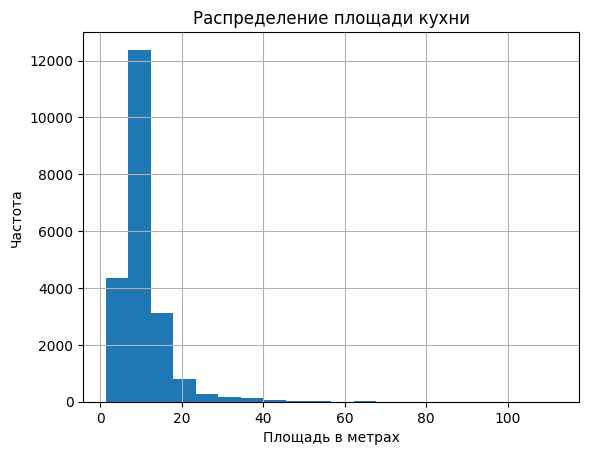

In [9]:
df['rooms_limited'] = df['rooms'].where(df['rooms']<=6, 6)
df['kitchen_area'].hist(bins=20)
plt.title('Распределение площади кухни')
plt.xlabel('Площадь в метрах')
plt.ylabel('Частота')
plt.show()

df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = (df
                                                     .assign(kitchen_total_rate=df['kitchen_area']/df['total_area'])
                                                     .groupby('rooms_limited')['kitchen_total_rate']
                                                     .transform('median')
                                                     .fillna(0)
                                                     *df['total_area'])
df.drop('rooms_limited', axis=1, inplace=True)


В теории, можно было бы попробовать восстановить расстояние до центра, ближайшего парка и пруда медианными значениями для населённого пункта. Однако в данном случае эти параметры указаны только для населённых пунктов внутри С-Пб (Петергоф, Ломоносов и т.д.), а для всех остальных пропущены. Убедимся в этом, посмотрев на списки пунктов с указанными расстояниями до центра и без таковых, а также на количество пропусков в тех пунктах, где есть хотя бы одно непропущенное значение:

In [10]:
print(df[~df['cityCenters_nearest'].isna()]['locality_name'].unique()) 
print(df[df['cityCenters_nearest'].isna()]['locality_name'].unique())
len(df[(df['cityCenters_nearest'].isna()) & (df['locality_name'].isin(df[~df['cityCenters_nearest'].isna()]['locality_name'].unique()))])


['Санкт-Петербург' 'посёлок Шушары' 'посёлок Парголово' 'Ломоносов'
 'Петергоф' 'Пушкин' 'Колпино' 'Кронштадт' 'посёлок Металлострой'
 'Павловск' 'Сестрорецк' 'Красное Село' 'посёлок Понтонный' 'Зеленогорск'
 'посёлок Молодёжное' 'посёлок Стрельна' 'посёлок Александровская'
 'посёлок Песочный' 'посёлок Петро-Славянка' 'посёлок Репино'
 'посёлок Сапёрный' 'поселок Лисий Нос' 'посёлок Левашово'
 'посёлок Белоостров' 'посёлок Лисий Нос' 'посёлок Усть-Ижора']
['городской посёлок Янино-1' 'посёлок Мурино' 'Сертолово'
 'деревня Кудрово' 'Коммунар' 'поселок городского типа Красный Бор'
 'Гатчина' 'поселок Мурино' 'деревня Фёдоровское' 'Выборг' 'Кировск'
 'деревня Новое Девяткино' 'Санкт-Петербург'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'деревня Пикколово' 'Всеволожск'
 'Волхов' 'Кингисепп' 'Приозерск' 'деревня Куттузи' 'посёлок Аннино'
 'поселок городского типа Ефим

69

Таким образом, восстановить значения в большинстве населённых пунктов не получится. При этом именно там и сосредоточены почти все пропуски, а в Петербурге и его частях пропусков почти нет. Значит, придётся оставить пропущенные значения.

### Изменение типов данных

В столбцах с ценой, количеством этажей, количеством балконов, количеством дней от публикации до снятия и количеством парков (озёр) по смыслу явно должны находиться целые числа. Кроме того, дата публикации, очевидно, является датой. Изменим типы столбцов соответствующим образом:

In [11]:
columns_list = ['last_price', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']
df[columns_list] = df[columns_list].astype(int)
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 23565 non-null  int64         
 1   total_images          23565 non-null  int64         
 2   last_price            23565 non-null  int32         
 3   total_area            23565 non-null  float64       
 4   first_day_exposition  23565 non-null  datetime64[ns]
 5   rooms                 23565 non-null  int64         
 6   ceiling_height        23565 non-null  float64       
 7   floors_total          23565 non-null  int32         
 8   living_area           23565 non-null  float64       
 9   floor                 23565 non-null  int64         
 10  is_apartment          23565 non-null  bool          
 11  studio                23565 non-null  bool          
 12  open_plan             23565 non-null  bool          
 13  kitchen_area    

### Устранение неявных дубликатов

Посмотрим на названия населённых пунктов:

In [12]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Можно заметить, что зачастую одни и те же населённые пункты имеют разные приставки (деревня, село и т.д.). Удалим их все и убедимся, что дубликатов не осталось:

In [13]:
## Вариант с явным перечислением приставок
# df['locality_name'] = (df['locality_name']
#                        .str.replace('ё', 'е')
#                        .replace(['поселок ', 'село ', 'при железнодорожной ', 'станции ', 'городской ', 'городского типа ', 'коттеджный ', 'садовое товарищество ', 'деревня ', 'садоводческое некоммерческое товарищество'], '', regex=True)
# ) 

df['locality_name'] = (df['locality_name']
                       .str.replace('ё', 'е')
                       .replace(r'^[а-я\s]+', '', regex=True)
) 
df['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодежное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

## Расчёт и добавление новых столбцов

Создадим новые столбцы с ценой за метр, днём недели, месяцем и годом публикации объявления, округлённым до целого расстоянием до центра в километрах и типом этажа (первый, последний, другой):

In [14]:
df['price_per_meter'] = (df['last_price']/df['total_area']).round(2)
df['exposition_weekday'] = df['first_day_exposition'].dt.weekday
df['exposition_month'] = df['first_day_exposition'].dt.month
df['exposition_year'] = df['first_day_exposition'].dt.year
df['cityCenters_nearest_km'] = (df['cityCenters_nearest']/1000).round()
def get_floor_type(x):
    if x['floor'] == 1:
        return 'первый'
    elif x['floor'] == x['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_type'] = df.apply(get_floor_type, axis=1)
df.head(10)


,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,exposition_weekday,exposition_month,exposition_year,cityCenters_nearest_km,floor_type
0,0,20,13000000,108.00,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0,120370.37,3,3,2019,16.0,другой
1,1,7,3350000,40.40,2018-12-04,1,2.75,11,18.600000,1,False,False,False,11.000000,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.79,1,12,2018,19.0,первый
2,2,10,5196000,56.00,2015-08-20,2,2.55,5,34.300000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.71,3,8,2015,14.0,другой
3,3,0,64900000,159.00,2015-07-24,3,2.60,14,86.189359,9,False,False,False,20.430899,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.10,4,7,2015,7.0,другой
4,4,2,10000000,100.00,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.00,1,6,2018,8.0,другой
5,5,10,2890000,30.40,2018-09-10,1,2.65,12,14.400000,5,False,False,False,9.100000,0,Янино-1,NaN,NaN,0,NaN,0,NaN,55,95065.79,0,9,2018,NaN,другой
6,6,6,3700000,37.30,2017-11-02,1,2.75,26,10.600000,6,False,False,False,14.400000,1,Парголово,52996.0,19143.0,0,NaN,0,NaN,155,99195.71,3,11,2017,19.0,другой
7,7,5,7915000,71.60,2019-04-18,2,2.75,24,35.365596,22,False,False,False,18.900000,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,0,110544.69,3,4,2019,12.0,другой
8,8,20,2900000,33.16,2018-05-23,1,2.75,27,15.430000,26,False,False,False,8.810000,0,Мурино,NaN,NaN,0,NaN,0,NaN,189,87454.76,2,5,2018,NaN,другой
9,9,18,5400000,61.00,2017-02-26,3,2.50,9,43.600000,7,False,False,False,6.500000,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289,88524.59,6,2,2017,15.0,другой


## Исследовательский анализ данных

### Выявление выбросов

Для начала сохраним исходный размер выборки, чтобы в конце отсеивания нетипичных значений проконтролировать долю удалённых данных:

In [15]:
start_size = len(df)
start_size

23565

Рассмотрим распределение общей площади недвижимости. После построения первой гистограммы становится ясно, что существует длинный "хвост" из редких значений. Возьмём, к примеру, значение 300 и используем его как пороговое, убедившись, что потеряется не слишком много значений. Затем ещё раз построим гистограмму, чтобы лучше увидеть структуру распределения и удостовериться, что оно похоже на пуассоновское:

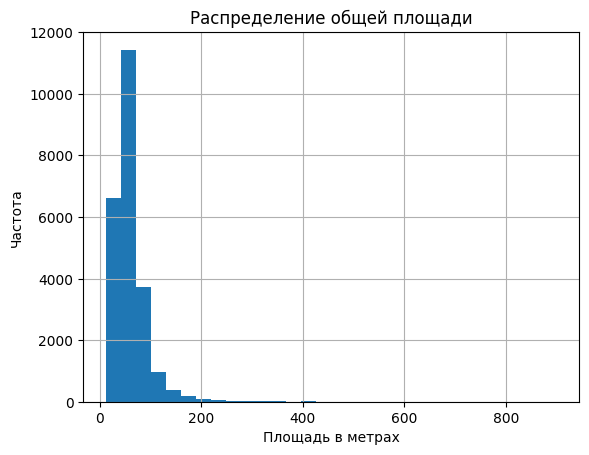

61


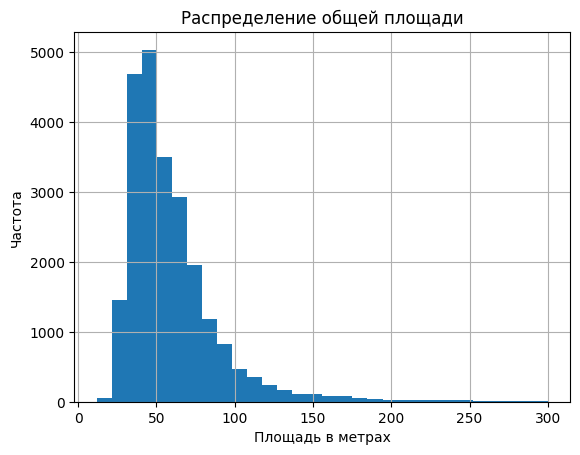

In [16]:
df['total_area'].hist(bins=30)
plt.title('Распределение общей площади')
plt.xlabel('Площадь в метрах')
plt.ylabel('Частота')
plt.show()

print(df[df['total_area']>300]['total_area'].count())
df = df[df['total_area']<=300]
df['total_area'].hist(bins=30)
plt.title('Распределение общей площади')
plt.xlabel('Площадь в метрах')
plt.ylabel('Частота')
plt.show()

Рассмотрим распределение жилой площади недвижимости. После построения первой гистограммы становится ясно, что существует небольшой "хвост" из редких значений. Возьмём, к примеру, значение 200 и используем его как пороговое, убедившись, что потеряется не слишком много значений. Затем ещё раз построим гистограмму, чтобы лучше увидеть структуру распределения и удостовериться, что оно примерно похоже на пуассоновское:

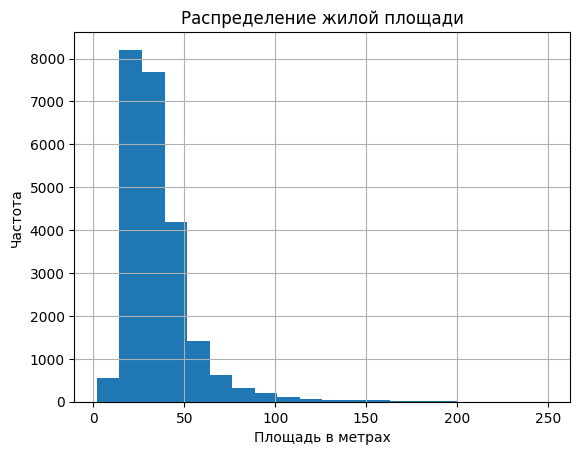

4


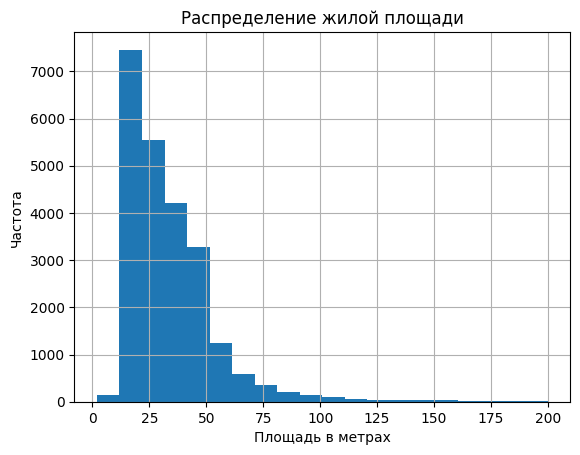

In [17]:
df['living_area'].hist(bins=20)
plt.title('Распределение жилой площади')
plt.xlabel('Площадь в метрах')
plt.ylabel('Частота')
plt.show()

print(df[df['living_area']>200]['living_area'].count())
df = df[df['living_area']<=200]
df['living_area'].hist(bins=20)
plt.title('Распределение жилой площади')
plt.xlabel('Площадь в метрах')
plt.ylabel('Частота')
plt.show()

Рассмотрим распределение площади кухни в недвижимости. После построения первой гистограммы становится ясно, что существует длинный "хвост" из редких значений. Возьмём, к примеру, значение 50 и используем его как пороговое, убедившись, что потеряется не слишком много значений. Кроме того, отсеем квартиры без кухни (появились при заполнении пропусков, так как имеются квартиры с нулём комнат, для которых, что логично, площадь кухни ни разу не указана), чтобы лучше увидеть распределение среди остальных. Затем ещё раз построим гистограмму, чтобы лучше увидеть структуру распределения и удостовериться, что оно в целом похоже на пуассоновское:

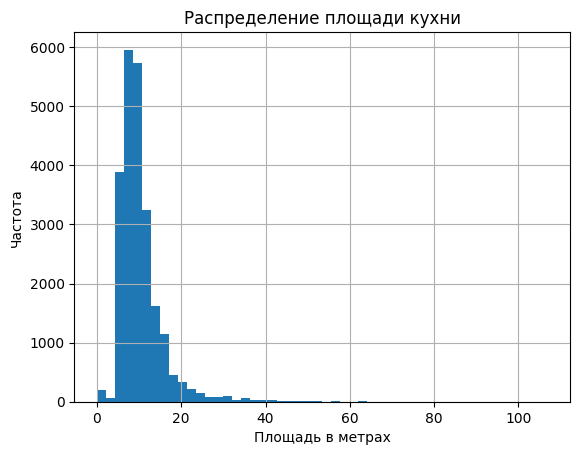

36


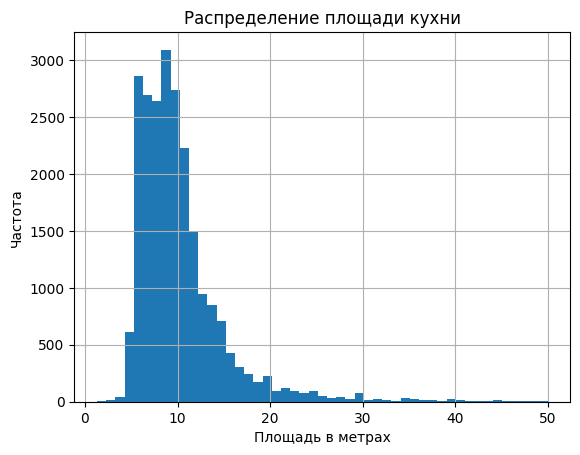

In [18]:
df['kitchen_area'].hist(bins=50)
plt.title('Распределение площади кухни')
plt.xlabel('Площадь в метрах')
plt.ylabel('Частота')
plt.show()

print(df[df['kitchen_area']>50]['kitchen_area'].count())
df = df[df['kitchen_area']<=50]
df[df['kitchen_area']>=0.001]['kitchen_area'].hist(bins=49)
plt.title('Распределение площади кухни')
plt.xlabel('Площадь в метрах')
plt.ylabel('Частота')
plt.show()

Рассмотрим распределение последней цены недвижимости. После построения первой гистограммы становится ясно, что существует длинный "хвост" из редких значений. Возьмём, к примеру, значение 25 млн и используем его как пороговое, убедившись, что потеряется не слишком много значений. Затем ещё раз построим гистограмму, чтобы лучше увидеть структуру распределения и удостовериться, что оно  похоже на пуассоновское:

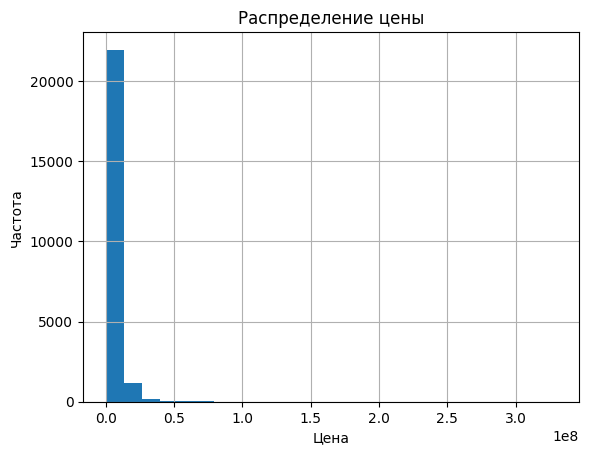

386


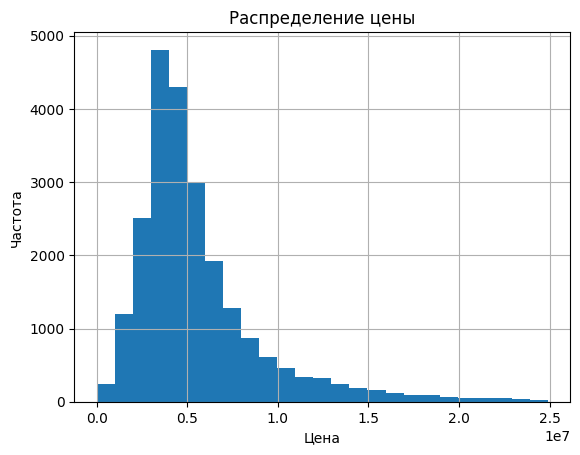

In [19]:
df['last_price'].hist(bins=25)
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

print(df[df['last_price']>25000000]['last_price'].count())
df = df[df['last_price']<25000000]
df['last_price'].hist(bins=25)
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

Рассмотрим распределение количества комнат. После построения первой гистограммы становится ясно, что существует "хвост" из редких значений. Возьмём, к примеру, значение 7 комнат и используем его как пороговое, убедившись, что потеряется не слишком много значений. Затем ещё раз построим гистограмму, чтобы лучше увидеть структуру распределения и удостовериться, что оно  похоже на пуассоновское:

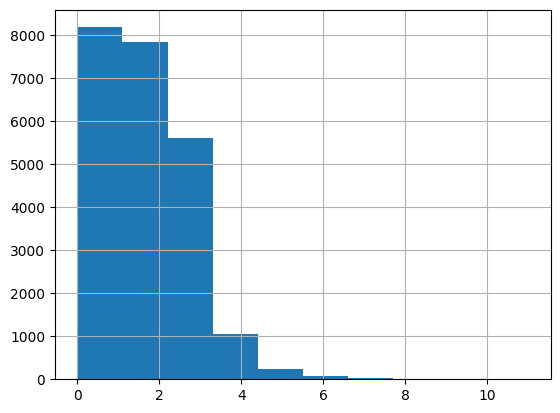

12


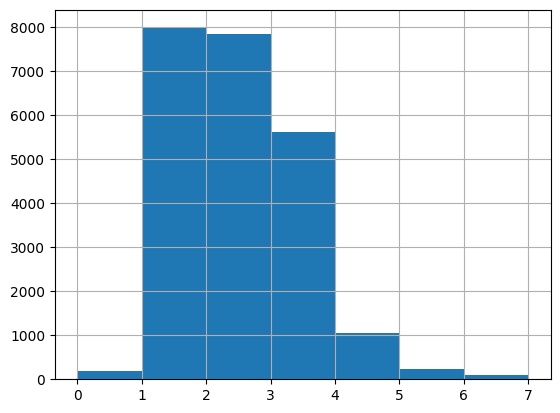

In [20]:
df['rooms'].hist()
plt.show()
print(df[df['rooms']>7]['rooms'].count())
df = df[df['rooms']<=7]
df['rooms'].hist(bins=7)
plt.show()

Рассмотрим распределение высоты потолков. После построения первой гистограммы становится ясно, что существует "хвост" из редких значений. Эти значения настолько велики, что явно включают в себя ошибку, связанную с лишним разрядом. Будем считать, что все значения более 10 метров ошибочны и разделим их на 10. Затем удалим неправдоподобные значения менее 2 и более 5 метров и ещё раз построим гистограмму, чтобы лучше увидеть структуру распределения и удостовериться, что оно отчасти похоже на пуассоновское, хотя и содержит характерные пики в районе наиболее часто встречающихся в России значений высоты потолков:

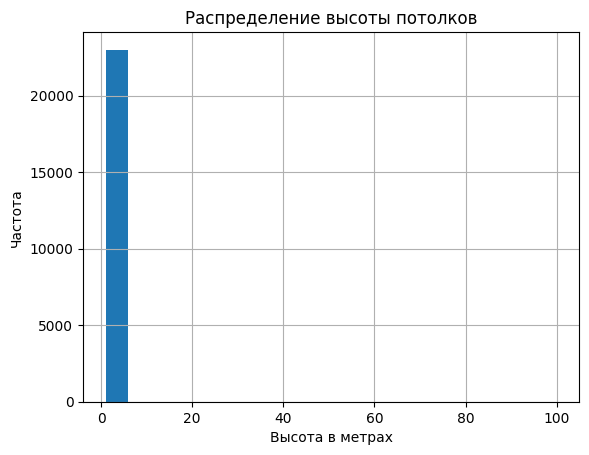

7
5


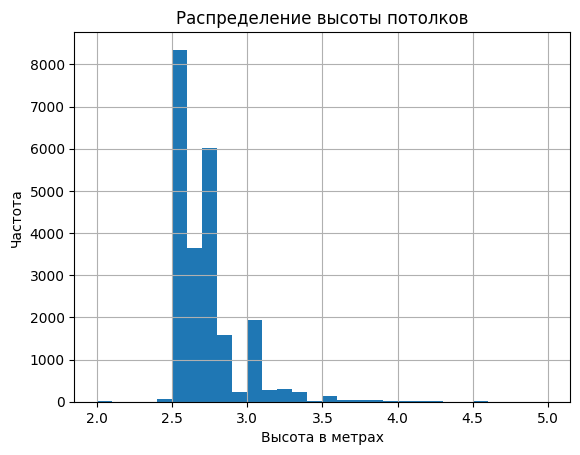

In [21]:
df['ceiling_height'].hist(bins=20)
plt.title('Распределение высоты потолков')
plt.xlabel('Высота в метрах')
plt.ylabel('Частота')
plt.show()

df.loc[df['ceiling_height']>=10, 'ceiling_height'] = df.loc[df['ceiling_height']>=10, 'ceiling_height']/10
print(df[df['ceiling_height']>5]['ceiling_height'].count())
df = df[df['ceiling_height']<=5]
print(df[df['ceiling_height']<2]['ceiling_height'].count())
df = df[df['ceiling_height']>=2]
df['ceiling_height'].hist(bins=30)
plt.title('Распределение высоты потолков')
plt.xlabel('Высота в метрах')
plt.ylabel('Частота')
plt.show()

Распределение типов этажа ожидаемо показывает, что квартир на первом и последнем этажах примерно поровну и заметно меньше, чем на других в сумме:

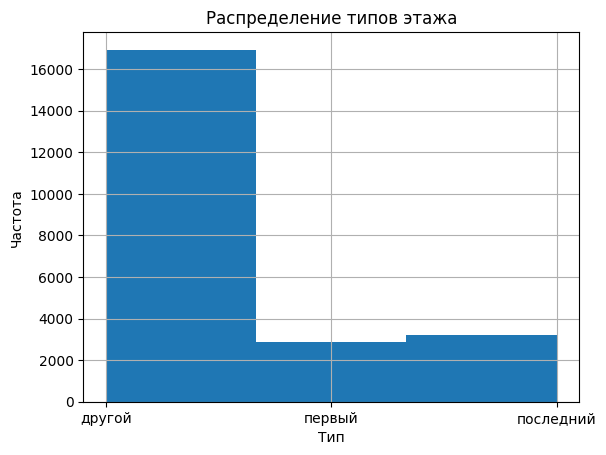

In [22]:
df['floor_type'].hist(bins=3)
plt.title('Распределение типов этажа')
plt.xlabel('Тип')
plt.ylabel('Частота')
plt.show()

Рассмотрим распределение количества этажей. После построения первой гистограммы становится ясно, что существует "хвост" из редких значений. Возьмём значение 37 этажей (максимальное количество этажей в жилом доме в Петербурге) и используем его как пороговое, убедившись, что потеряется не слишком много значений. Затем ещё раз построим гистограмму, чтобы лучше увидеть структуру распределения и удостовериться, что оно не очень похоже на пуассоновское за счёт характерных пиков для 5, 9, 12 и некоторых других частых в России значений количества этажей:

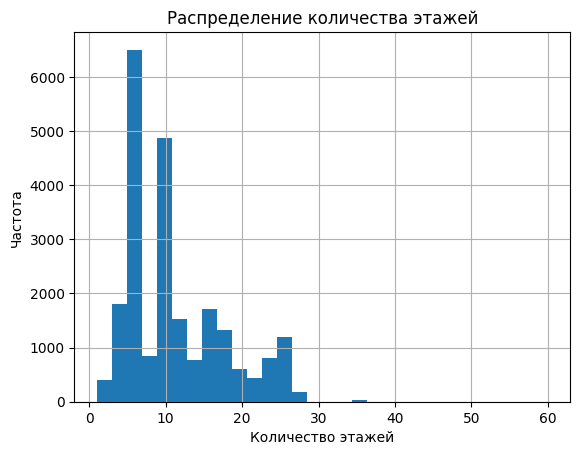

2


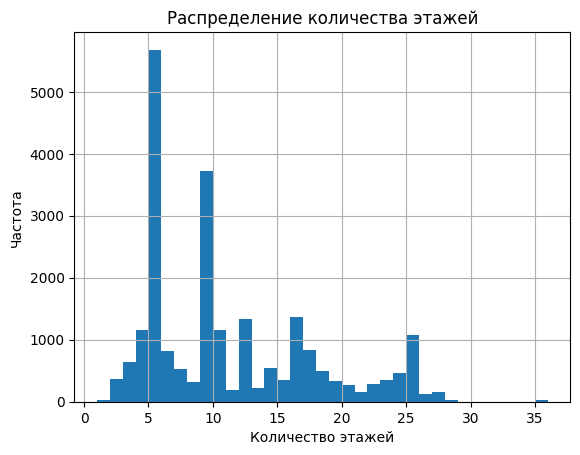

In [23]:
df['floors_total'].hist(bins=30)
plt.title('Распределение количества этажей')
plt.xlabel('Количество этажей')
plt.ylabel('Частота')
plt.show()

print(df[df['floors_total']>37]['floors_total'].count())
df = df[df['floors_total']<=37]
df['floors_total'].hist(bins=df['floors_total'].max()-df['floors_total'].min())
plt.title('Распределение количества этажей')
plt.xlabel('Количество этажей')
plt.ylabel('Частота')
plt.show()

Распределение расстояния до центра не содержит аномальных значений и в целом похоже на пуассоновское с небольшими перепадами, соответствующими неравномерному распределению жилой застройки:

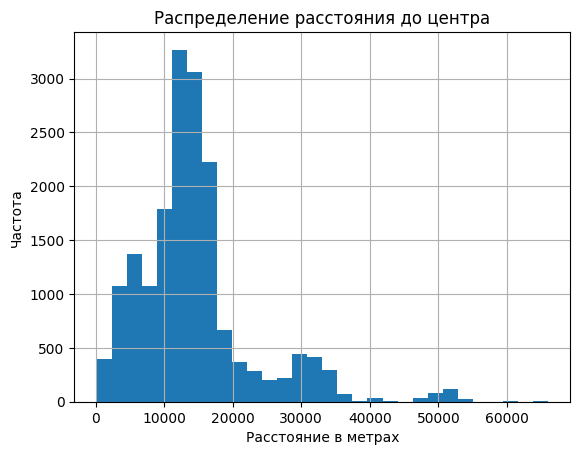

In [24]:
df['cityCenters_nearest'].hist(bins=30)
plt.title('Распределение расстояния до центра')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота')
plt.show()

Распределение расстояния до ближайшего парка не содержит аномальных значений и в целом весьма похоже на пуассоновское:

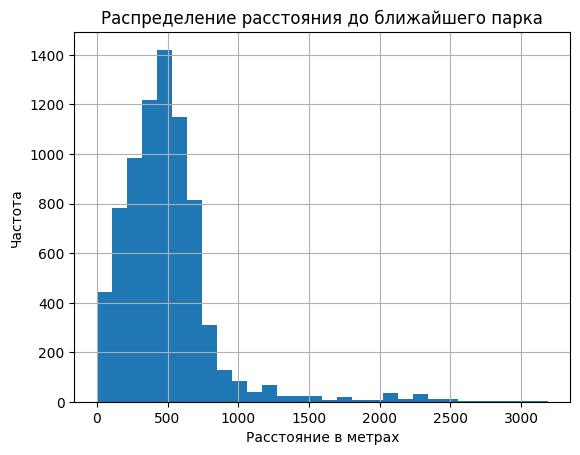

In [25]:
df['parks_nearest'].hist(bins=30)
plt.title('Распределение расстояния до ближайшего парка')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота')
plt.show()

Посчитаем долю оставшихся значений после фильтрации, она вполне приемлема:

In [26]:
round(len(df)/start_size, 2)

0.98

### Исследование длительности продажи квартир

По результатам подсчёта среднего, медианы и 95-квантиля, было выявлено, что характерное значение длительности продажи составляет 73 дня. При этом в 75% случаев для продажи требуется не более 196 дней, а значения более 597 дней совсем маргинальны и встречаются лишь в 5% случаев. Быстрые продажи за 23 дня и менее встречаются только в 25% случаев и относительно редки:

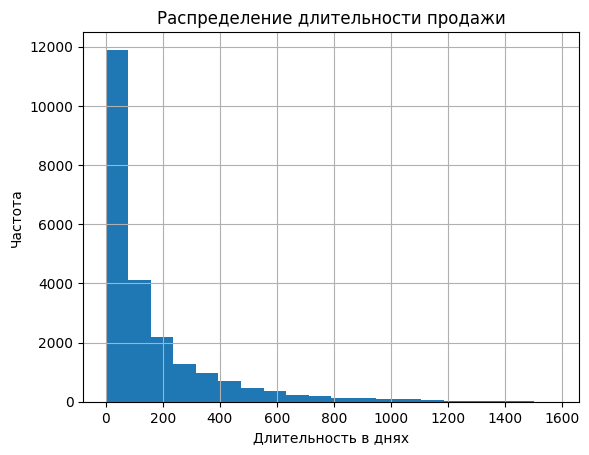

count    23024.000000
mean       154.818711
std        211.020579
min          0.000000
25%         23.000000
50%         73.000000
75%        196.000000
max       1580.000000
Name: days_exposition, dtype: float64


596.8

In [27]:
df['days_exposition'].hist(bins=20)
plt.title('Распределение длительности продажи')
plt.xlabel('Длительность в днях')
plt.ylabel('Частота')
plt.show()

print(df['days_exposition'].describe())
round(df['days_exposition'].quantile(q=0.95), 1)


### Исследование факторов, влияющих на полную стоимость объекта

##### Общая площадь

В целом, прослеживается довольно чёткая связь между общей площадью и стоимостью. Коэффициент корреляции составляет 0.78 и на диаграммах рассеивания прослеживается линия тренда.

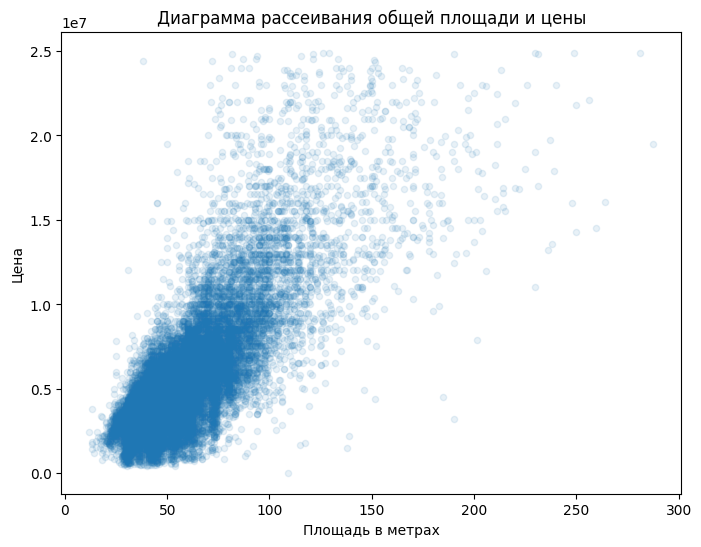

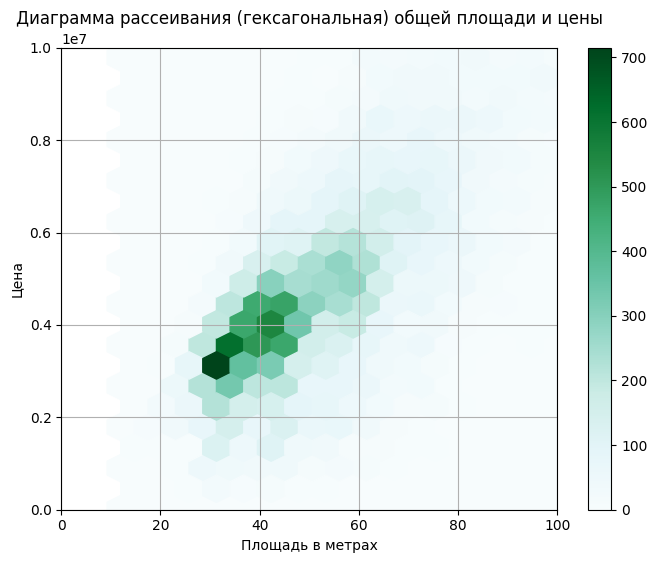

0.78

In [28]:
df.plot(x='total_area', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.1)
plt.title('Диаграмма рассеивания общей площади и цены')
plt.xlabel('Площадь в метрах')
plt.ylabel('Цена')
plt.show()

df.plot(x='total_area', y='last_price', kind='hexbin', gridsize=50, figsize=(8, 6), sharex=False, grid=True, xlim=(0, 100), ylim=(0, 10**7))
plt.title('Диаграмма рассеивания (гексагональная) общей площади и цены')
plt.xlabel('Площадь в метрах')
plt.ylabel('Цена')
plt.show()

round(df['total_area'].corr(df['last_price']), 2)

##### Жилая площадь

Заметна некоторая положительная связь между жилой площадью и стоимостью. Коэффициент корреляции составляет 0.68 и на диаграммах рассеивания угадывается слабая линия тренда. Большие колебания площади (общей и жилой) при росте цены, возможно, объясняются тем, что элитное жилье может и не иметь большой площади, но стоить дорого за счёт расположения, продвинутого дизайна, хорошей инфраструктуры и других факторов:

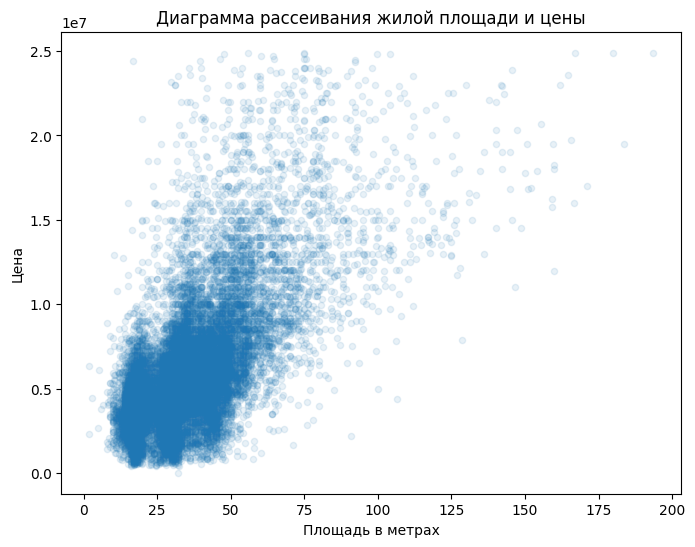

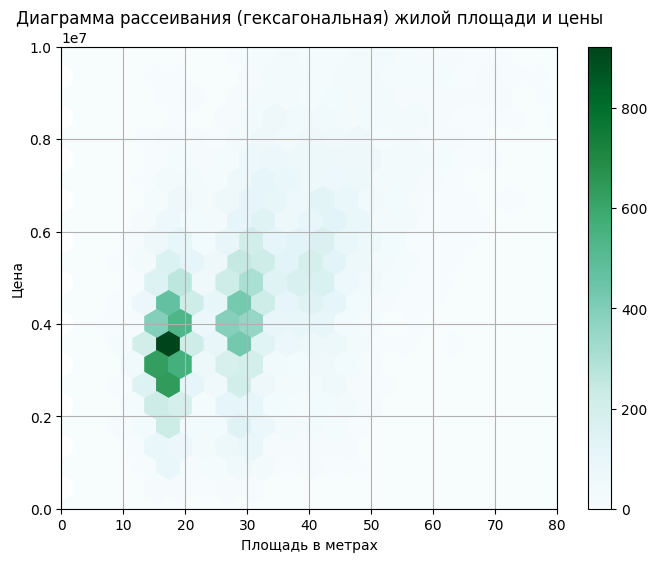

0.68

In [29]:
df.plot(x='living_area', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.1)
plt.title('Диаграмма рассеивания жилой площади и цены')
plt.xlabel('Площадь в метрах')
plt.ylabel('Цена')
plt.show()

df.plot(x='living_area', y='last_price', kind='hexbin', gridsize=50, figsize=(8, 6), sharex=False, grid=True, xlim=(0, 80), ylim=(0, 10**7))
plt.title('Диаграмма рассеивания (гексагональная) жилой площади и цены')
plt.xlabel('Площадь в метрах')
plt.ylabel('Цена')
plt.show()

round(df['living_area'].corr(df['last_price']), 2)

##### Площадь кухни

Что с учётом нулевых значений, что без таковых, заметна лишь весьма слабая положительная связь между площадью кухни и стоимостью. Коэффициент корреляции составляет 0.59 и на диаграммах рассеивания угадывается крайне размытая линия тренда:

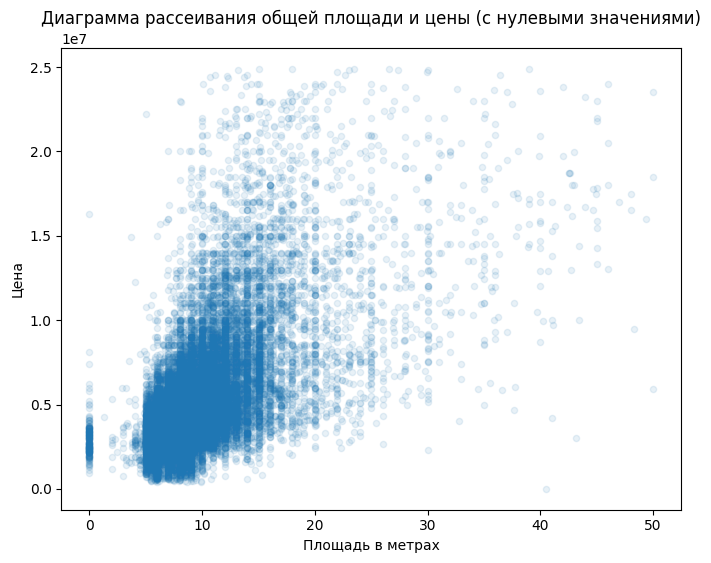

22832


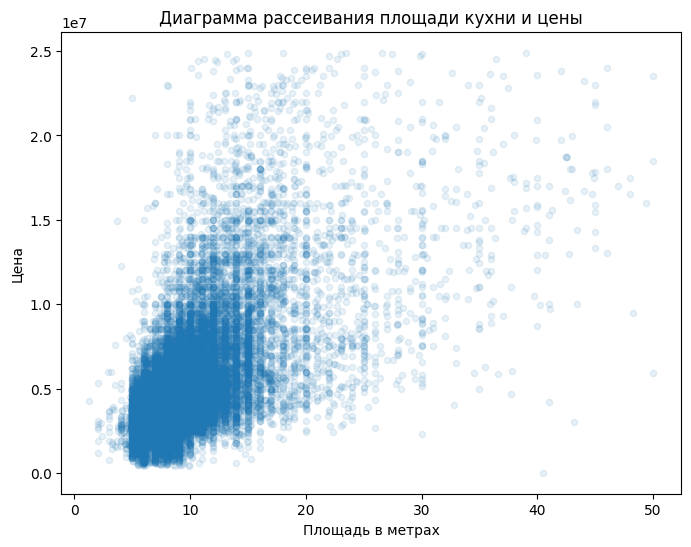

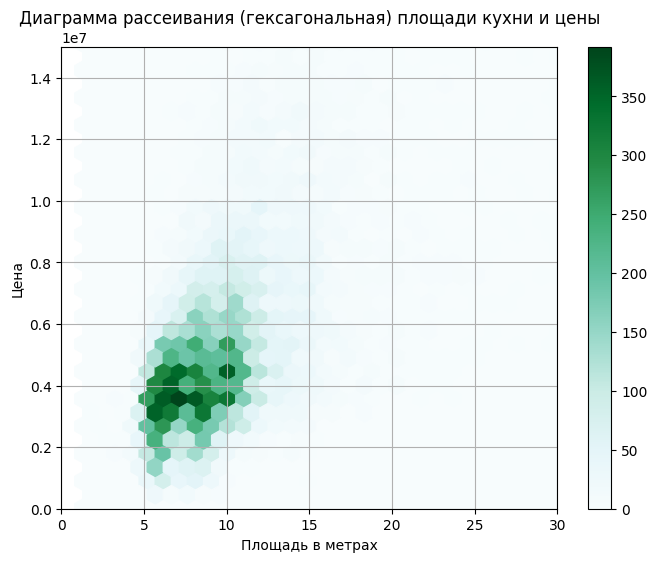

Коэффициент корреляции цены и площади кухни (без нулевых значений): 0.59
Коэффициент корреляции средней цены и площади кухни: 0.59


In [30]:
df.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.1)
plt.title('Диаграмма рассеивания общей площади и цены (с нулевыми значениями)')
plt.xlabel('Площадь в метрах')
plt.ylabel('Цена')
plt.show()

df_kitchen = df[df['kitchen_area']>0]
print(len(df_kitchen))
df_kitchen.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.1)
plt.title('Диаграмма рассеивания площади кухни и цены')
plt.xlabel('Площадь в метрах')
plt.ylabel('Цена')
plt.show()

df_kitchen.plot(x='kitchen_area', y='last_price', kind='hexbin', gridsize=50, figsize=(8, 6), sharex=False, grid=True, xlim=(0, 30), ylim=(0, 1.5*10**7))
plt.title('Диаграмма рассеивания (гексагональная) площади кухни и цены')
plt.xlabel('Площадь в метрах')
plt.ylabel('Цена')
plt.show()

print(f'Коэффициент корреляции цены и площади кухни (без нулевых значений): {round(df["kitchen_area"].corr(df["last_price"]), 2)}')
print(f'Коэффициент корреляции средней цены и площади кухни: {round(df_kitchen["kitchen_area"].corr(df_kitchen["last_price"]), 2)}')

##### Количество комнат

В целом, на каждое количество комнат приходится слишком много разных данных, чтобы можно было говорить о сколько-нибудь достоверной связи (коэффициент корреляции 0.51). При этом связь средней (и медианной) цены с количеством комнат просматривается чётко, как на графике, так и за счёт коэффицента корреляции, равного 0.99:

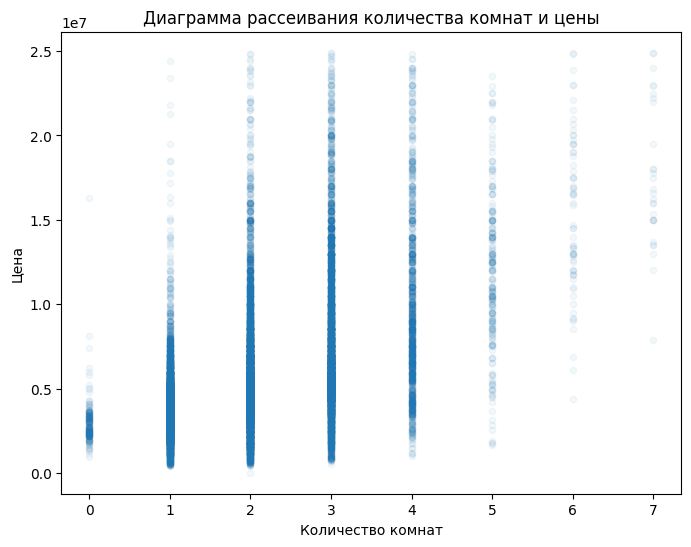

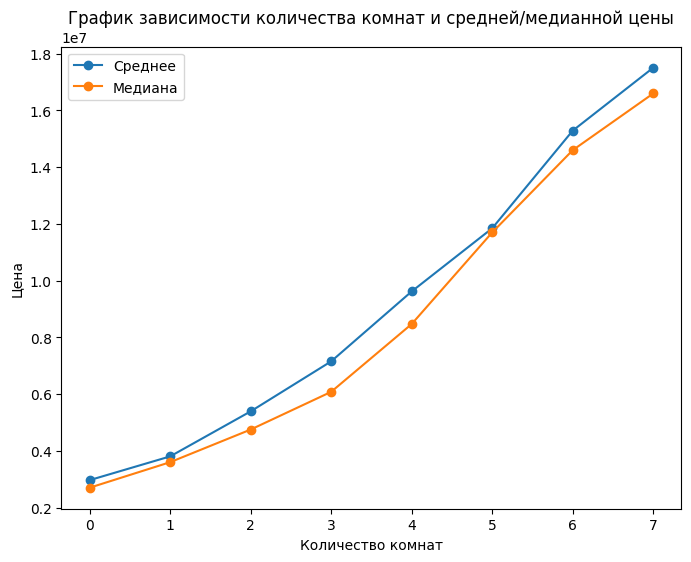

Коэффициент корреляции цены и количества комнат: 0.51
Коэффициент корреляции средней цены и количества комнат: 0.99


In [31]:
df.plot(x='rooms', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.05)
plt.title('Диаграмма рассеивания количества комнат и цены')
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()

room_table = df.pivot_table(index='rooms', values='last_price', aggfunc=['mean', 'median']).droplevel(1, axis=1)
room_table.plot(style='-o', figsize=(8, 6), ylabel='last_price')
plt.legend(['Среднее', 'Медиана'])
plt.title('График зависимости количества комнат и средней/медианной цены')
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()

print(f'Коэффициент корреляции цены и количества комнат: {round(df["rooms"].corr(df["last_price"]), 2)}')
print(f'Коэффициент корреляции средней цены и количества комнат: {round(pd.Series(room_table.index.values).corr(room_table["mean"]), 2)}')

##### Тип этажа

Связь средней (и медианной) цены с типом этажа просматривается на графике довольно чётко. Видно, что в среднем на рынке менее всего ценятся квартиры на первом этаже, затем идёт последний этаж, а другие ценятся больше всего:

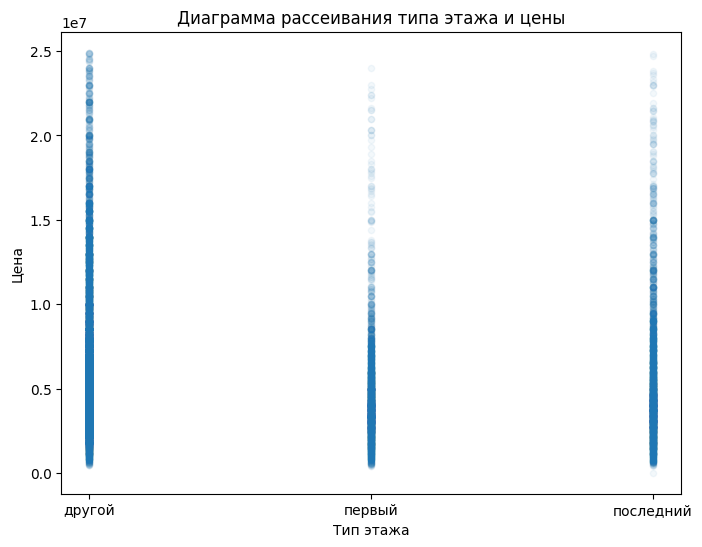

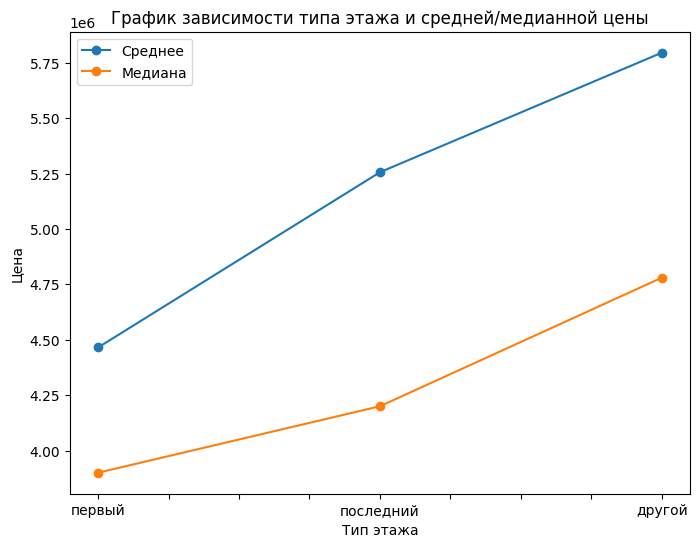

In [32]:
df.plot(x='floor_type', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.05)
plt.title('Диаграмма рассеивания типа этажа и цены')
plt.xlabel('Тип этажа')
plt.ylabel('Цена')
plt.show()

(df
 .pivot_table(index='floor_type', values='last_price', aggfunc=['mean', 'median'])
 .droplevel(1, axis=1).sort_values(by='median')
 .plot(style='-o', figsize=(8, 6), ylabel='last_price')
)
plt.legend(['Среднее', 'Медиана'])
plt.title('График зависимости типа этажа и средней/медианной цены')
plt.xlabel('Тип этажа')
plt.ylabel('Цена')
plt.show()

##### День недели

Хаотичный график средней цены отражает небольшие недельные изменения. В частности, из него можно заключить, что самый невыгодные для продажи дни - с пятницы по воскресенье, а самые выгодные - будние дни, особенно вторник, что примерно похоже на имеющиеся сведения о рынке.

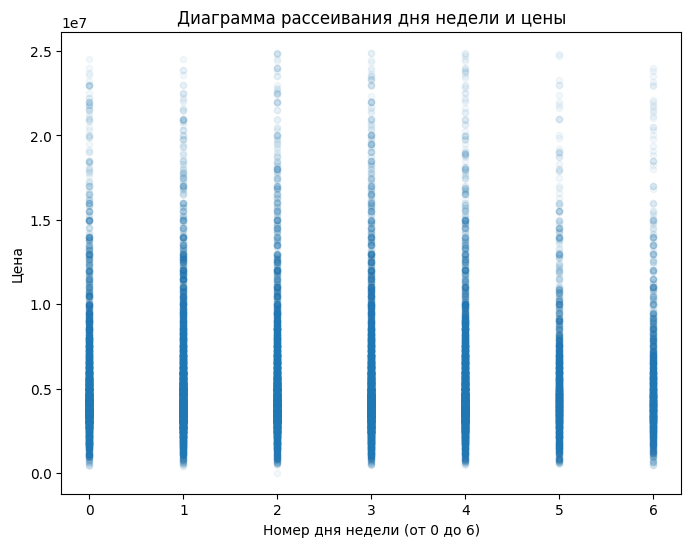

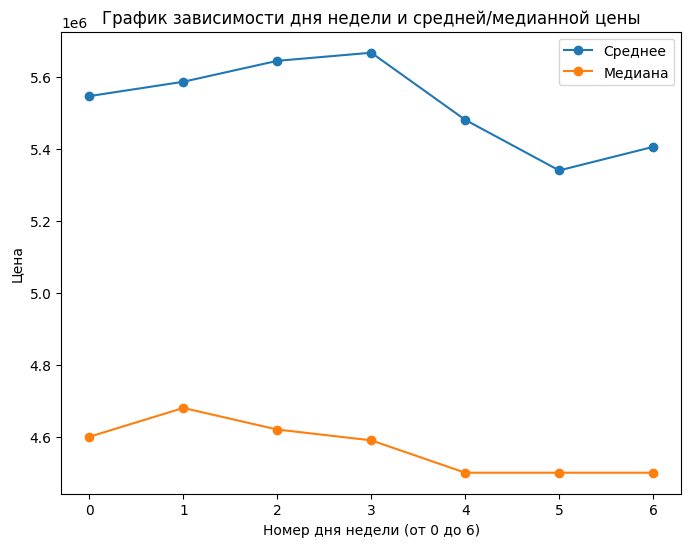

In [33]:
df.plot(x='exposition_weekday', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.05)
plt.title('Диаграмма рассеивания дня недели и цены')
plt.xlabel('Номер дня недели (от 0 до 6)')
plt.ylabel('Цена')
plt.show()

df.pivot_table(index='exposition_weekday', values='last_price', aggfunc=['mean', 'median']).plot(style='-o', figsize=(8, 6), ylabel='last_price')
plt.legend(['Среднее', 'Медиана'])
plt.title('График зависимости дня недели и средней/медианной цены')
plt.xlabel('Номер дня недели (от 0 до 6)')
plt.ylabel('Цена')
plt.show()

##### Месяц

Хаотичный график средней цены отражает небольшие сезонные изменения. В частности, из него можно заключить, что самый невыгодный для продажи месяц - июнь, а самый выгодный - сентябрь, что примерно похоже на имеющиеся сведения о рынке.

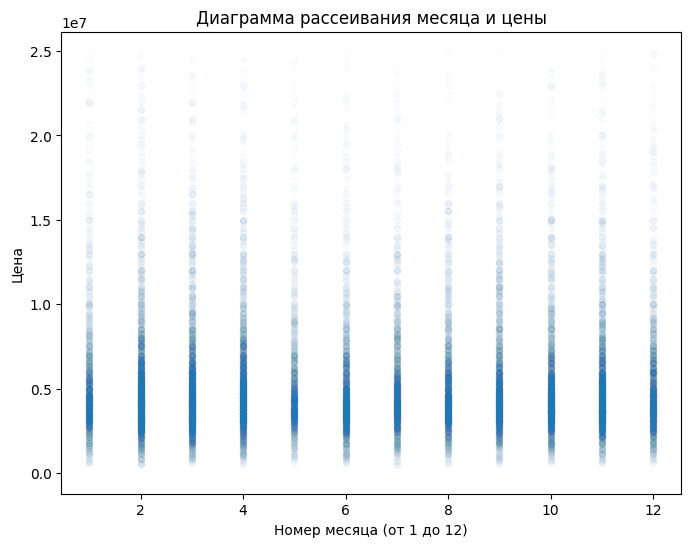

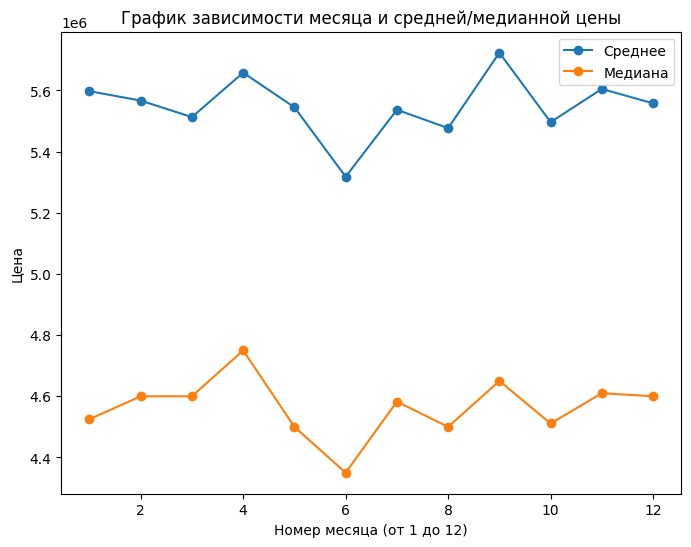

In [34]:
df.plot(x='exposition_month', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.01)
plt.title('Диаграмма рассеивания месяца и цены')
plt.xlabel('Номер месяца (от 1 до 12)')
plt.ylabel('Цена')
plt.show()

df.pivot_table(index='exposition_month', values='last_price', aggfunc=['mean', 'median']).plot(style='-o', figsize=(8, 6), ylabel='last_price')
plt.legend(['Среднее', 'Медиана'])
plt.title('График зависимости месяца и средней/медианной цены')
plt.xlabel('Номер месяца (от 1 до 12)')
plt.ylabel('Цена')
plt.show()

##### Год

График средних указывает на большую среднюю стоимость проданных квартир в 2014 году, однако при проверке оказывается, что сведений про этот год очень мало и выводы следует делать с осторожностью. В остальном можно отметить снижение средней цены в 2016 году, стабильные значения с 2016 по 2018 и подъём в 2019.

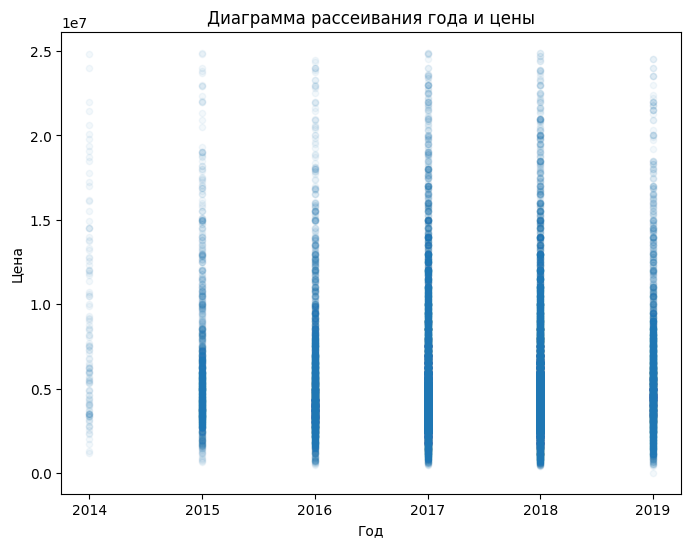

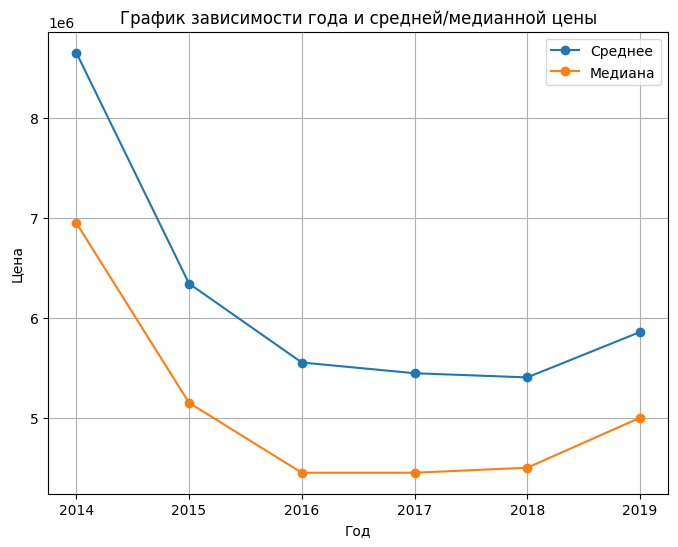

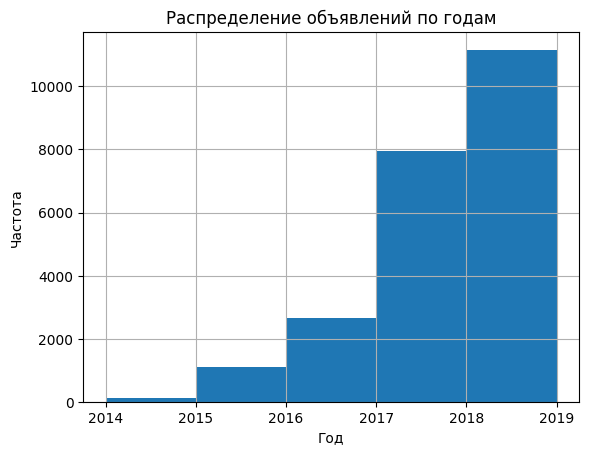

122

In [35]:
df.plot(x='exposition_year', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.05)
plt.title('Диаграмма рассеивания года и цены')
plt.xlabel('Год')
plt.ylabel('Цена')
plt.show()

df.pivot_table(index='exposition_year', values='last_price', aggfunc=['mean', 'median']).plot(style='-o', figsize=(8, 6), ylabel='last_price', grid=True)
plt.legend(['Среднее', 'Медиана'])
plt.title('График зависимости года и средней/медианной цены')
plt.xlabel('Год')
plt.ylabel('Цена')
plt.show()

df['exposition_year'].hist(bins=5)
plt.title('Распределение объявлений по годам')
plt.xlabel('Год')
plt.ylabel('Частота')
plt.show()

len(df[df['exposition_year']==2014])

### Средняя цена квадратного метра в 10 самых населённых пунктах

Ожидаемо самыми населёнными оказались довольно крупные города во главе с Петербургом, с большим отрывом. В нём же и наибольшая стоимость жилья за квадратный метр, не сильно отстают Пушкин и Кудрово. Наименьшая стоимость квадратного метра в Выборге, Всеволожске и Гатчине, что соотносится с печальным состоянием этих городов и удалённостью от Петербурга в случае Выборга.

In [36]:
df_top_localities = df[df['locality_name'].isin(df
                                                .groupby('locality_name')['locality_name']
                                                .count()
                                                .sort_values(ascending=False)[:10]
                                                .index.values
                                               )]
(df_top_localities
 .pivot_table(index='locality_name', values='price_per_meter', aggfunc=['mean', 'count'])
 .droplevel(1, axis=1)
 .sort_values(by='mean', ascending=False)
)

,mean,count
locality_name,,
Санкт-Петербург,109541.908370,15126
Пушкин,102229.042806,360
Кудрово,95260.846128,470
Парголово,90175.913089,327
Мурино,86041.116024,586
Шушары,78551.344647,439
Колпино,75333.295816,337
Гатчина,68746.146515,307
Всеволожск,68654.473970,398


### Средняя цена недвижимости на километр удалённости от центра Санкт-Петербурга

Можно наблюдать, что большая часть квартира расположена на расстоянии от 4 до 17 км от центра города. После построения диаграммы рассеяния было решено не брать в рассчёт расстояния, на которые приходится менее 50 объявлений. 

В целом, наблюдается ожидаемый тренд на снижение цены по мере удаления от центра города. Есть небольшой скачок в цене на расстоянии в 4-5 километров от центра, что может быть вызвано расположением примерно на этом расстоянии элитных районов вроде Петровского, Крестовского и Каменного островов. Также, начиная с удалённости в 12 км цена не сильно меняется, слегка колеблясь. Судя по всему, на таких расстояниях удалённость от центра уже не играет большой роли:

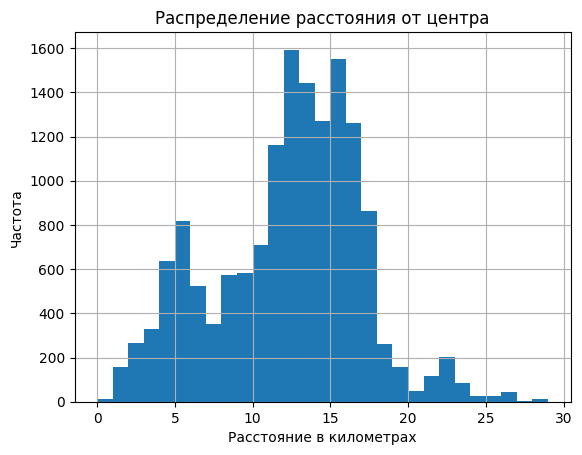

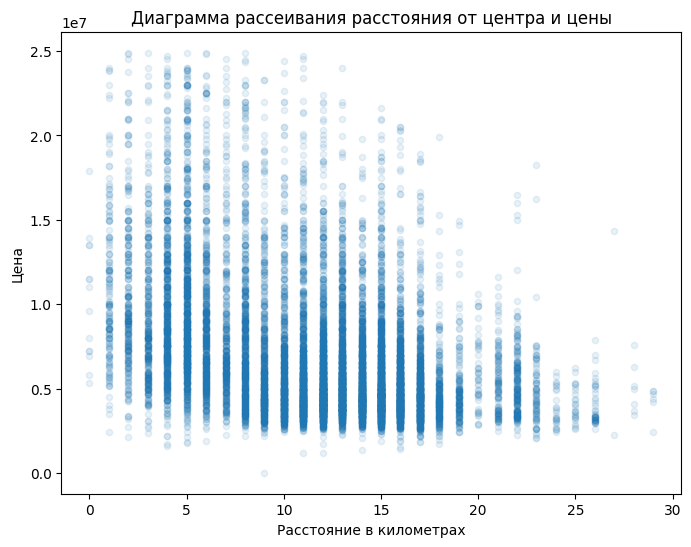

,mean,median,count
cityCenters_nearest_km,,,
0,10198571,10290000,14
1,10996667,9950000,159
2,10599108,9325000,268
3,9359895,8200000,328
4,9833633,8725246,637
5,10026435,8710840,816
6,9050070,7995000,524
7,8449193,6825000,350
8,8435347,7200000,572


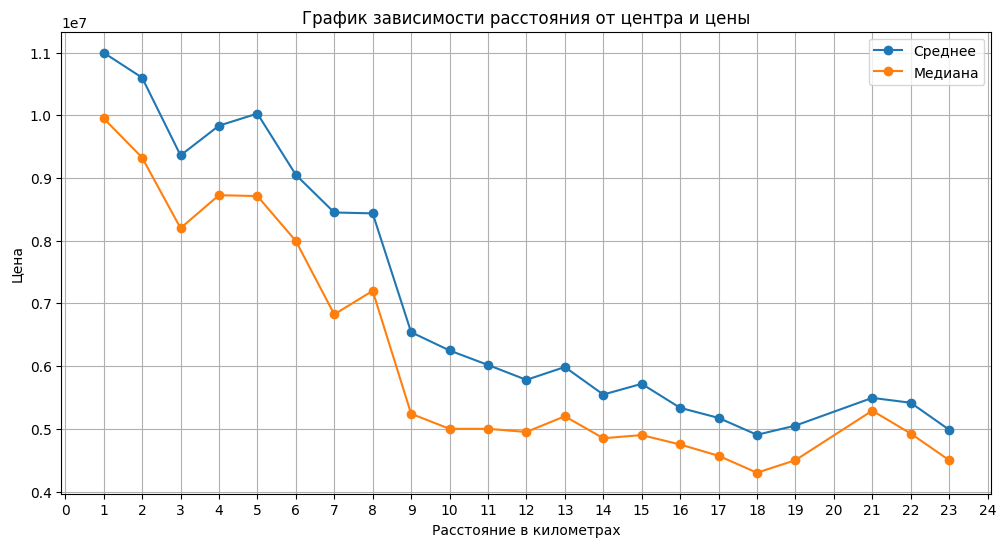

In [37]:
pd.options.display.float_format = '{:.0f}'.format
df_spb = df[df['locality_name']=='Санкт-Петербург']
df_spb['cityCenters_nearest_km'].hist(bins=29)
plt.title('Распределение расстояния от центра')
plt.xlabel('Расстояние в километрах')
plt.ylabel('Частота')
plt.show()

df_spb.plot(x='cityCenters_nearest_km', y='last_price', kind='scatter', figsize=(8, 6), alpha=0.1)
plt.title('Диаграмма рассеивания расстояния от центра и цены')
plt.xlabel('Расстояние в километрах')
plt.ylabel('Цена')
plt.show()

mean_median_price = df_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc=['mean', 'median', 'count']).droplevel(1, axis=1)
display(mean_median_price)
mean_median_price = mean_median_price[mean_median_price['count']>50]
mean_median_price[['mean', 'median']].plot(style='-o', figsize=(12, 6), ylabel='last_price', grid=True, xticks=range(25))
plt.legend(['Среднее', 'Медиана'])
plt.title('График зависимости расстояния от центра и цены')
plt.xlabel('Расстояние в километрах')
plt.ylabel('Цена')
plt.show()

## Вывод

1. В рамках проекта исследовался архив объявлений о продаже недвижимости в Санкт-Петербурге и области на основе набора данных из 23699 вхождений с сайта Яндекс.Недвижимость. Работа велась с такими признаками, как:
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — общая площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении
  
2. В ходе предобработки были произведены следующие действия:
- обнаружены и исправлены отсутствующие значения на месте нулей и отрицательных логических значений в столбцах . Пропуски в названии населённых пунктов и количестве этажей были крайне малочисленны и невосстановимы, поэтому были удалены. Пропущенные высоты потолков были восстановлены как медианные для соответствующей этажности. Пропуски в расстоянии до центра, ближайшего парка и ближайшего пруда были систематическими для городов вне Петербурга, в следствие чего их не удалось ни восстановить, ни удалить с сохранением структуры данных. 
- изменены на int типы переменных last_price', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition; изменён на datetime тип переменной first_day_exposition.
- устранены неявные дубликаты в названиях населённых пунктов (удалены приставки "деревня", "село" и прочее; буква ё заменена на е)

3. Были добавлены следующие столбцы:
- price_per_meter - цена одного квадратного метра
- exposition_day - день недели публикации объявления (от 0 до 6)
- exposition_month - месяц публикации объявления
- exposition_day - год публикации объявления
- floor_type - тип этажа квартиры (значения — «первый», «последний», «другой»)
- cityCenters_nearest_km - расстояние до центра города в километрах (переведено в км с округлением до целых значений).
  
4. Наконец, был проведён исследовательский анализ данных:
    - построены гистограммы и удалены нетипичные значения для параметров общая площадь, жилая площадь, площадь кухни, цена объекта, количество комнат, высота потолков, тип этажа квартиры, общее количество этажей в доме, расстояние до центра города, расстояние до ближайшего парка. В большинстве случаев удалялись "хвосты" со слишком редкими значениями. Для высоты потолков было сочтено, что значения более 10 метров следует сократить в 10 раз как явно ошибочные, затем были удалены неправдоподобные значения менне 2 или более 5 метров. Везде получены распределения, близкие к пуассоновским; все отклоняющиеся пики значений совпадают с ожидаемыми (как, например, большое количество 9-этажных домов при очень малом количестве 7 и 8-этажных). Единственное исключение - распределение типов этажа - ожидаемо показывает, что квартир на первом и последнем этажах примерно поровну и заметно меньше, чем на других в сумме.
    - вычислены характеристики распределения длительности продаж. Было выявлено, что характерное (медианное) значение длительности продажи составляет 73 дня. При этом в основном продажи проиходят за срок от 23 до 196 дней (межквартильный размах), а в 5% случаев он превышает 597 дней, за счёт чего среднее весьма велико (155 дней).
    - изучены факторы, влияющие на цену. Значительнее всего влияют общая площадь (коэффициент корреляции 0.78) и жилая площадь (0.68). Отсутствие кухни не влияет на цену, но на для квартир с кухней прослеживается слабая положительная связь площади кухни и цены квартиры (0.59). Такие параметры, как количество комнат и тип этажа, коррелируют со средней ценой в категории, для количества комнат эта корреляция имеет коэффициент 0.99. Соотносится со средней ценой и дата размещения объявления: продажи дороже в будние дни и особенно вторник, а в пятницу-воскресенье дешевле; средняя цена также выше всего в сентябре, а ниже - в июне; данные по 2014 году малочисленны и ненадёжны, а в остальном можно отметить снижение средней цены в 2016 году, стабильные значения с 2016 по 2018 и подъём в 2019.
    - посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Ожидаемо самыми населёнными оказались довольно крупные города во главе с Петербургом, с большим отрывом. В нём же и наибольшая стоимость жилья за квадратный метр, не сильно отстают Пушкин и Кудрово. Наименьшая стоимость квадратного метра в Выборге, Всеволожске и Гатчине, что соотносится с печальным состоянием этих городов и удалённостью от Петербурга в случае Выборга.
    - посчитана средняя цена каждого километра удалённости от центра; расстояния с менее 50 объявлений отброшены. В целом, был зафиксирован ожидаемый тренд на снижение цены по мере удаления от центра города с небольшим скачком в цене на расстоянии в 4-5 километров от центра (вероятно, влияние элитных районов), а также довольно стабильной ценой при расстоянии в 12 км и более (расстояние перестаёт быть существенным фактором).